# Fully Connected Neural Networks in PyTorch
### Companion Notebook for the Medium Article

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader  # For custom dataset and batching

## Data Collection, Preprocessing, and Exploration

In [3]:
import os
import requests
import gzip
import shutil

# Updated URLs for MNIST dataset
urls = [
    "https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz",
    "https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz",
    "https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz",
    "https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz"
]

# Directory to store data
os.makedirs("./data", exist_ok=True)

# Function to download files
def download_file(url, save_dir="./data"):
    filename = os.path.join(save_dir, url.split("/")[-1])
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        print(f"Downloading {filename}...")
        with open(filename, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
        print(f"Downloaded {filename}")
    else:
        print(f"Failed to download {url}: {response.status_code}")

# Download all files
for url in urls:
    download_file(url)

# Function to extract .gz files
def extract_gz_files(source_dir="./data"):
    for file in os.listdir(source_dir):
        if file.endswith(".gz"):
            file_path = os.path.join(source_dir, file)
            extracted_path = file_path.replace(".gz", "")
            print(f"Extracting {file_path}...")
            with gzip.open(file_path, 'rb') as f_in:
                with open(extracted_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            print(f"Extracted to {extracted_path}")

# Extract all downloaded files
extract_gz_files("./data")



Downloaded ./data/train-images-idx3-ubyte.gz
Downloaded ./data/train-labels-idx1-ubyte.gz
Downloaded ./data/t10k-images-idx3-ubyte.gz
Downloaded ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz...
Extracted to ./data/t10k-images-idx3-ubyte
Extracting ./data/train-images-idx3-ubyte.gz...
Extracted to ./data/train-images-idx3-ubyte
Extracting ./data/train-labels-idx1-ubyte.gz...
Extracted to ./data/train-labels-idx1-ubyte
Extracting ./data/t10k-labels-idx1-ubyte.gz...
Extracted to ./data/t10k-labels-idx1-ubyte


In [4]:
import numpy as np
import struct

def load_images(file_path):
    with open(file_path, 'rb') as f:
        # Read the header
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        assert magic == 2051, "Invalid magic number for image file!"
        # Read the image data and reshape it
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
    return images

def load_labels(file_path):
    with open(file_path, 'rb') as f:
        # Read the header
        magic, num_labels = struct.unpack(">II", f.read(8))
        assert magic == 2049, "Invalid magic number for label file!"
        # Read the label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

# Load training data
train_images = load_images('./data/train-images-idx3-ubyte')
train_labels = load_labels('./data/train-labels-idx1-ubyte')

# Load test data
test_images = load_images('./data/t10k-images-idx3-ubyte')
test_labels = load_labels('./data/t10k-labels-idx1-ubyte')

# Print shapes for verification
print(f"Train Images Shape: {train_images.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Labels Shape: {test_labels.shape}")

Train Images Shape: (60000, 28, 28)
Train Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28)
Test Labels Shape: (10000,)


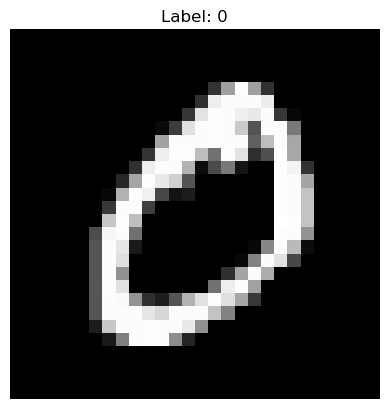

In [11]:
import matplotlib.pyplot as plt

# Select an image and label to display
index = 1  # Change this to see other images
image = train_images[index].astype(np.float32)  # Convert to float for better rendering
label = train_labels[index]

# Plot the image
def show_image(image,label):
    plt.imshow(image, cmap='gray', interpolation='nearest')  # Ensure grayscale rendering
    plt.title(f"Label: {label}")
    plt.axis('off')  # Remove axis for clarity
    plt.show()

show_image(image,label)

## Creating a Custom PyTorch Dataset

In [7]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Custom MNIST dataset.
        Args:
            images: NumPy array or tensor of shape (N, 28, 28).
            labels: NumPy array or tensor of shape (N,).
            transform: Optional. A callable that applies transformations to the images.
        """
        # Convert NumPy arrays to tensors during initialization
        self.images = torch.tensor(images, dtype=torch.float32) #Default is usually float32
        self.labels = torch.tensor(labels, dtype=torch.long) # Type long for classification
        self.transform = transform if transform else self.default_transform() #Apply default transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """
        Fetch an image and its corresponding label.
        Args:
            idx: Index of the image and label to retrieve.
        Returns:
            Tuple (transformed_image, label).
        """
        # Access the image and label directly as tensors
        image = self.images[idx].unsqueeze(0)  # Add channel dimension (C, H, W)
        label = self.labels[idx]

        # Apply the transform
        image = self.transform(image)

        return image, label

    def default_transform(self):
        """
        Define the default transformation pipeline for MNIST.
        Returns:
            A callable transform.
        """
        return transforms.Compose([
            transforms.Normalize((0.5,), (0.5,)),  # Normalize to mean 0.5, std 0.5
        ])

In [8]:
MNISTDataset(train_images, train_labels).images.shape

torch.Size([60000, 28, 28])

In [9]:
MNISTDataset(train_images, train_labels).default_transform()

Compose(
    Normalize(mean=(0.5,), std=(0.5,))
)

In [10]:
MNISTDataset(train_images, train_labels).__getitem__(1)[0].shape# Return "image" at idx 1

torch.Size([1, 28, 28])

In [12]:
MNISTDataset(train_images, train_labels).__getitem__(1)[1] # Return label at idx 1

tensor(0)

In [13]:
train_loader = DataLoader(MNISTDataset(train_images, train_labels), batch_size=64, shuffle=True)
test_loader = DataLoader(MNISTDataset(test_images, test_labels), batch_size=64)

## Defining A Simple Network Architecture

In [15]:
import torch.nn as nn

class SimpleFCNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128, output_size=10):
        """
        Fully connected neural network with a single hidden layer.
        Args:
            input_size (int): Number of input features (e.g., 28*28 for MNIST).
            hidden_size (int): Size of the hidden layer.
            output_size (int): Number of output classes (e.g., 10 for MNIST digits).
        """
        super(SimpleFCNN, self).__init__()
        
        # Define the network layers
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),  # Input to hidden layer
            nn.ReLU(),                           # Activation function
            nn.Linear(hidden_size, output_size)  # Hidden to output layer
        )
    
    def forward(self, x):
        """
        Forward pass through the network.
        Args:
            x (torch.Tensor): Input tensor (batch_size, input_size).
        Returns:
            torch.Tensor: Output tensor (batch_size, output_size).
        """
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.network(x)


In [16]:
SimpleFCNN(input_size=28*28, hidden_size=128, output_size=10)

SimpleFCNN(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [46]:
# Initialize model
basic_model = SimpleFCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(basic_model.parameters(), lr=0.001)  # Learning rate = 0.001

In [47]:
# Shows all trainable parameters
for name, param in basic_model.state_dict().items():
    print(f"{name}: {param.shape}")

network.0.weight: torch.Size([128, 784])
network.0.bias: torch.Size([128])
network.2.weight: torch.Size([10, 128])
network.2.bias: torch.Size([10])


## Model Evaluation

In [49]:
def evaluate_model(model, test_loader):
    """
    Evaluate a PyTorch model on a test dataset.
    
    Args:
        model (torch.nn.Module): The model to evaluate
        test_loader (DataLoader): DataLoader containing the test dataset
        
    Returns:
        float: Accuracy percentage on the test dataset
    """
    # Set the model to evaluation mode
    model.eval()
    
    correct = 0
    total = 0
    
    # Disable gradient computation for evaluation
    with torch.no_grad():
        for images, labels in test_loader:
            # Forward pass
            outputs = model(images)
            
            # Get predicted class (highest score)
            _, predicted = torch.max(outputs, 1)
            
            # Update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate and return accuracy
    accuracy = 100 * correct / total
    return accuracy  # Return the value instead of printing it

### Evaluate Before Training

In [50]:
evaluate_model(basic_model, test_loader)

13.7

## Model Training

In [51]:
def train_epoch(model, train_loader, criterion, optimizer, verbose=True):
    """
    Train a PyTorch model for one epoch.
    
    Args:
        model (nn.Module): PyTorch model to train
        train_loader (DataLoader): DataLoader for training data
        criterion: Loss function
        optimizer: Optimizer for updating weights
        verbose (bool): Whether to print progress
        
    Returns:
        float: Average loss for the epoch
    """
    # Set model to training mode
    model.train()
    
    # Initialize tracking variables
    total_loss = 0
    total_batches = len(train_loader)
    
    # Training loop
    for _, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        total_loss += loss.item()
    
    # Calculate average loss
    avg_loss = total_loss / total_batches
    
    return avg_loss


In [52]:
train_epoch(basic_model, train_loader, criterion, optimizer, verbose=True)

0.9196185972025273

### Evaluate Model After 1 Epoch

In [53]:
evaluate_model(basic_model, test_loader)

93.09

### Run Additional Epochs

In [54]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5):
    """
    Train a model for multiple epochs and evaluate performance.
    
    Args:
        model: PyTorch model to train
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        criterion: Loss function
        optimizer: Optimizer for updating weights
        num_epochs: Number of epochs to train
    
    Returns:
        dict: Training history with losses and accuracies
    """
    history = {
        'train_loss': [],
        'test_accuracy': []
    }
    
    for epoch in range(num_epochs):
        print(f"\n=== Epoch {epoch + 1}/{num_epochs} ===")
        
        # Train for one epoch
        avg_loss = train_epoch(
            model=model,
            train_loader=train_loader,
            criterion=criterion,
            optimizer=optimizer
        )
        history['train_loss'].append(avg_loss)
        
        # Evaluate on test set
        test_acc = evaluate_model(model, test_loader)
        history['test_accuracy'].append(test_acc)
        
        print(f"Train Loss: {avg_loss:.4f}")
        print(f"Test Accuracy: {test_acc:.2f}%")
    
    return history

In [55]:
history = train_model(
    model=basic_model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=9
)


=== Epoch 1/9 ===
Train Loss: 0.2248
Test Accuracy: 94.21%

=== Epoch 2/9 ===
Train Loss: 0.1938
Test Accuracy: 95.02%

=== Epoch 3/9 ===
Train Loss: 0.1909
Test Accuracy: 94.42%

=== Epoch 4/9 ===
Train Loss: 0.1899
Test Accuracy: 93.31%

=== Epoch 5/9 ===
Train Loss: 0.1909
Test Accuracy: 95.02%

=== Epoch 6/9 ===
Train Loss: 0.1784
Test Accuracy: 94.62%

=== Epoch 7/9 ===
Train Loss: 0.1782
Test Accuracy: 94.53%

=== Epoch 8/9 ===
Train Loss: 0.1713
Test Accuracy: 94.52%

=== Epoch 9/9 ===
Train Loss: 0.1747
Test Accuracy: 94.53%


## Model Improvements

### Add Batch Normalization

In [148]:
class SimpleImprovedFCNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128, output_size=10):
        super(SimpleImprovedFCNN, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size), 
            nn.ReLU(),
            # nn.Dropout(0.3),  # Add dropout layer
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.network(x)

# Initialize new model and optimizer
improved_model = SimpleImprovedFCNN()
optimizer = optim.Adam(improved_model.parameters(), lr=0.001)  # Create new optimizer
criterion = nn.CrossEntropyLoss()

### Add Augmentation to Transforms

In [149]:
def get_mnist_augmented_transforms():
    """
    Create augmented transformation pipeline for MNIST dataset.
    Returns:
        transforms.Compose: Composition of transforms with augmentation
    """
    return transforms.Compose([
        transforms.RandomAffine(
            degrees=10,  # Random rotation up to 10 degrees
            translate=(0.1, 0.1),  # Random translation up to 10%
            scale=(0.9, 1.1),  # Random scaling between 90% and 110%
        ),
        transforms.RandomApply([
            transforms.GaussianBlur(kernel_size=3)  # Random Gaussian blur
        ], p=0.2),
        transforms.Normalize((0.5,), (0.5,)),  # Normalize to mean 0.5, std 0.5
    ])

# Usage example:
train_dataset_aug = MNISTDataset(
    train_images, 
    train_labels, 
    transform=get_mnist_augmented_transforms()  # Pass in augmented transforms
)

# For test data, use default transforms
test_dataset_aug = MNISTDataset(
    test_images, 
    test_labels  # Uses default_transform() internally
)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=64, shuffle=True)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=64)

In [160]:
class SimpleDropoutFCNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128, output_size=10):
        super(SimpleDropoutFCNN, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),  # Add dropout layer
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.network(x)

# Initialize new model and optimizer
dropout_model = SimpleDropoutFCNN()
optimizer = optim.Adam(dropout_model.parameters(), lr=0.001)  # Create new optimizer
criterion = nn.CrossEntropyLoss()

## Making a Single Prediction

In [181]:
MNISTDataset(train_images, train_labels).images[0].shape

torch.Size([28, 28])

In [182]:
MNISTDataset(train_images, train_labels).labels[0]

tensor(5)

In [185]:
import torch.nn.functional as F

image = MNISTDataset(train_images, train_labels).images[0]
image_label = MNISTDataset(train_images, train_labels).labels[0]
image = image.view(1, -1)

# Forward pass
logits = dropout_model(image)  # Get raw logits from the model

# Apply softmax to get probabilities
probabilities = F.softmax(logits, dim=1)

# Extract predicted class and its confidence
confidence, predicted_class = torch.max(probabilities, dim=1)

# Print results
print(f"Actual Class: {image_label}, Predicted Class: {predicted_class.item()}, Confidence: {confidence.item()*100:.1f}%")

Actual Class: 5, Predicted Class: 5, Confidence: 94.6%
